In [2]:
import torch

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),     # Resize to 64x64 or a size of your choice
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize the image between [-1, 1]
])

# Load your dataset
dataset_path = "C:/Users/Srinivasa Rao/OneDrive/Documents/GUVI Files/Datasets/raw-img"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class BetaVAE(nn.Module):
    def __init__(self, input_channels=3, latent_dim=10, beta=4):
        super(BetaVAE, self).__init__()
        self.beta = beta

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, 4, stride=2, padding=1),  # (B, 32, 32, 32)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # (B, 64, 16, 16)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # (B, 128, 8, 8)
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # (B, 64, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # (B, 32, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, 4, stride=2, padding=1),  # (B, 3, 64, 64)
            nn.Sigmoid()  # Output between 0 and 1
        )

    def encode(self, x):
        h = self.encoder(x).view(x.size(0), -1)  # Flatten for fully connected layer
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z).view(z.size(0), 128, 8, 8)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [6]:
def loss_function(recon_x, x, mu, logvar, beta=4):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss


In [8]:
# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BetaVAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50  # You can adjust the number of epochs

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        images, _ = batch
        images = images.to(device)

        # Forward pass
        recon_images, mu, logvar = model(images)
        loss = loss_function(recon_images, images, mu, logvar)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader)}")

# Save the fine-tuned model
torch.save(model.state_dict(), "fine_tuned_beta_vae.pth")


Epoch [1/50], Loss: 86703.21589336832
Epoch [2/50], Loss: 78552.3658754771
Epoch [3/50], Loss: 77976.25156846375
Epoch [4/50], Loss: 77682.26445014314
Epoch [5/50], Loss: 77464.43509363073
Epoch [6/50], Loss: 77268.5972566794
Epoch [7/50], Loss: 77106.00123449428
Epoch [8/50], Loss: 76948.67135019084
Epoch [9/50], Loss: 76803.11814766222
Epoch [10/50], Loss: 76713.4515326813
Epoch [11/50], Loss: 76585.31107466602
Epoch [12/50], Loss: 76534.5696505248
Epoch [13/50], Loss: 76412.44547948473
Epoch [14/50], Loss: 76340.46139670802
Epoch [15/50], Loss: 76279.88426168893
Epoch [16/50], Loss: 76212.93243976623
Epoch [17/50], Loss: 76169.04620706107
Epoch [18/50], Loss: 76110.79167461832
Epoch [19/50], Loss: 76033.09552719466
Epoch [20/50], Loss: 75984.17041686545
Epoch [21/50], Loss: 75958.50207538168
Epoch [22/50], Loss: 75911.84929627863
Epoch [23/50], Loss: 75869.37376550572
Epoch [24/50], Loss: 75819.14615338741
Epoch [25/50], Loss: 75791.56542223283
Epoch [26/50], Loss: 75733.31066913168

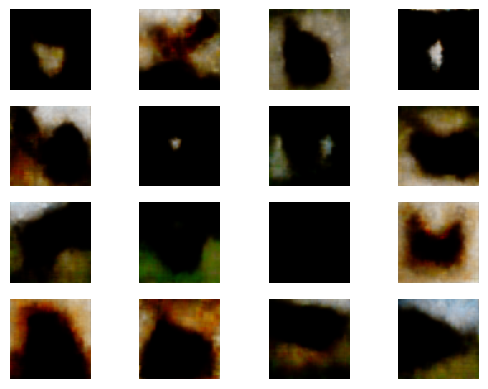

In [9]:
# Load the trained model
model = BetaVAE().to(device)
model.load_state_dict(torch.load("fine_tuned_beta_vae.pth"))
model.eval()

# Generate new images
with torch.no_grad():
    # Sample random latent vectors
    latent_vectors = torch.randn(16, 10).to(device)  # 16 samples, latent_dim = 10
    generated_images = model.decode(latent_vectors)

    # Move images to CPU and convert to numpy
    generated_images = generated_images.cpu().numpy()

    # Save or visualize generated images
    import matplotlib.pyplot as plt
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i].transpose(1, 2, 0))  # Convert from CHW to HWC
        plt.axis('off')
    plt.show()


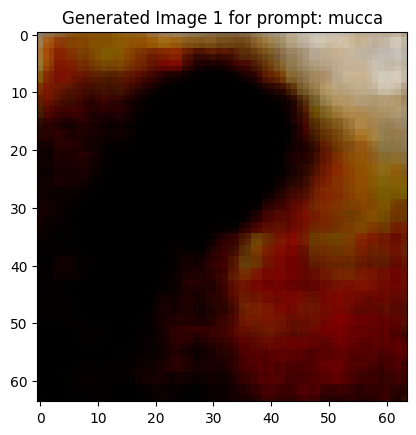

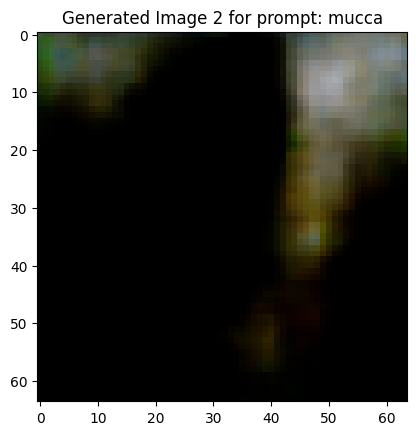

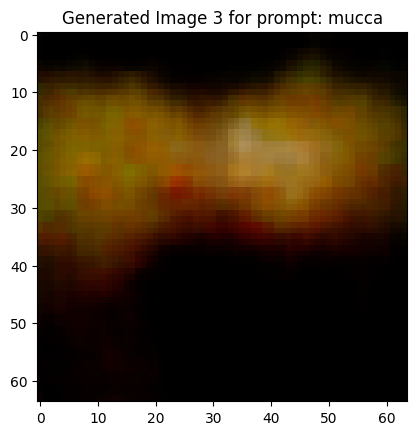

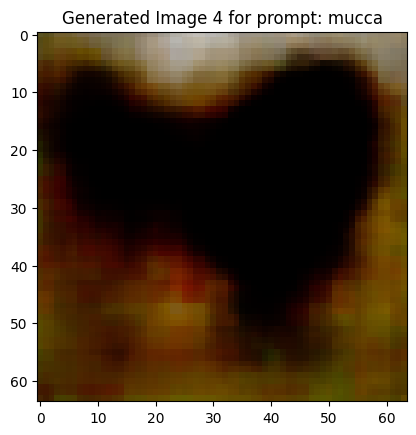

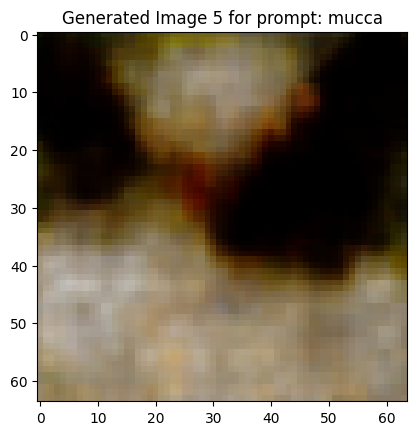

In [10]:
def generate_images(prompt, num_images=5):
    model.eval()
    with torch.no_grad():
        # Sample from the latent space (can adjust according to your dataset's structure)
        latent_samples = torch.randn(num_images, 10).to(device)  # 10 is the latent dim
        generated_images = model.decode(latent_samples).cpu()

        # Visualize generated images
        import matplotlib.pyplot as plt
        for i in range(num_images):
            plt.imshow(generated_images[i].permute(1, 2, 0))  # Convert to HWC format for plotting
            plt.title(f"Generated Image {i+1} for prompt: {prompt}")
            plt.show()

# Example of image generation with a prompt
generate_images('mucca', num_images=5)
